In [1]:
import os
from pathlib import Path
import numpy as np
import skimage.exposure
import rasterio
from io import StringIO
from scipy.sparse import coo_matrix
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import skimage.segmentation
import warnings
from scipy.sparse import coo_array
from scipy.io import loadmat
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['SimHei']  # 如果你显示中文，改为你系统支持的


In [2]:
def sample_train_from_candidate(candidate_truth, num_per_class=10, seed=42):
    """
    从 candidate_truth 中每个类别随机抽取固定数量作为新的训练样本。
    
    参数:
        candidate_truth: coo_matrix, 原始训练稀疏标签
        num_per_class: int, 每类抽取数量
        seed: int, 随机种子

    返回:
        train_truth: coo_matrix, 新的训练样本矩阵
    """
    np.random.seed(seed)

    rows, cols, labels = candidate_truth.row, candidate_truth.col, candidate_truth.data
    new_rows, new_cols, new_labels = [], [], []

    unique_classes = np.unique(labels)
    for cls in unique_classes:
        indices = np.where(labels == cls)[0]
        if len(indices) < num_per_class:
            raise ValueError(f"类 {cls} 样本不足，只有 {len(indices)} 个，无法抽取 {num_per_class} 个")
        chosen = np.random.choice(indices, num_per_class, replace=False)
        new_rows.extend(rows[chosen])
        new_cols.extend(cols[chosen])
        new_labels.extend(labels[chosen])

    shape = candidate_truth.shape
    train_truth = coo_matrix((new_labels, (new_rows, new_cols)), shape=shape, dtype=int)
    return train_truth
def _read_roi(path: Path, shape) -> coo_matrix:
    """
    读取 ENVI 软件导出 ROI 文件的 txt 文件，生成一个稀疏矩阵，表示每个像素点的类别标签。
    
    :param path: 文件路径，ENVI ROI 文件的路径
    :param shape: 图像的形状（height, width）
    :return: 一个稀疏矩阵，非零值表示像素点的类别标签
    """
    warnings.simplefilter("ignore", category=UserWarning)  # 忽略 loadtxt 的警告
    data = []
    rows = []
    cols = []
    current_label = 0
    buffer = ""

    with open(path, 'r') as f:
        for line in f:
            # 判断是否为新 ROI 的分割点
            if line.strip() == "" or line.startswith(";") or "ROI" in line:
                if buffer:  # 如果缓冲区有内容，解析为坐标数据
                    roi_data = np.loadtxt(StringIO(buffer), usecols=(2, 1), dtype=int)
                    if roi_data.size > 0:
                        r, c = roi_data.T
                        rows.extend(r)
                        cols.extend(c)
                        data.extend([current_label] * len(r))
                    buffer = ""  # 清空缓冲区
                # 如果遇到 ROI name 行，增加类别标签
                if "ROI name" in line:
                    current_label += 1
            else:
                buffer += line  # 将数据加入缓冲区

        # 处理最后一个 ROI
        if buffer:
            roi_data = np.loadtxt(StringIO(buffer), usecols=(2, 1), dtype=int)
            if roi_data.size > 0:
                r, c = roi_data.T
                rows.extend(r)
                cols.extend(c)
                data.extend([current_label] * len(r))

    warnings.resetwarnings()

    # 创建稀疏矩阵
    img = coo_matrix((data, (rows, cols)), shape=shape, dtype=int)
    return img


def load_houston2013(data_path: Path):
    """
    从本地路径加载 Houston2013 数据集。

    :param data_path: 数据集的根目录路径。
    :return: (casi, lidar, train_truth, test_truth, info)
    """
    FILES_PATH = data_path
    assert FILES_PATH.exists(), f"{FILES_PATH} does not exist. Please check the path."

    # 加载图像数据
    lidar = skimage.io.imread(FILES_PATH / '2013_IEEE_GRSS_DF_Contest_LiDAR.tif')[np.newaxis, :, :]  # (1, 349, 1905)
    casi = skimage.io.imread(FILES_PATH / '2013_IEEE_GRSS_DF_Contest_CASI.tif').transpose(2, 0, 1)   # (144, 349, 1905)

    # 加载训练集和测试集的真值
    train_truth = _read_roi(FILES_PATH / '2013_IEEE_GRSS_DF_Contest_Samples_TR.txt', (349, 1905))
    test_truth = _read_roi(FILES_PATH / '2013_IEEE_GRSS_DF_Contest_Samples_VA.txt', (349, 1905))

    # 数据集元信息
    info = {
        'n_band_casi': 144,
        'n_band_lidar': 1,
        'width': 1905,
        'height': 349,
        'label_dict': {
            1: 'Healthy grass',
            2: 'Stressed grass',
            3: 'Synthetic grass',
            4: 'Trees',
            5: 'Soil',
            6: 'Water',
            7: 'Residential',
            8: 'Commercial',
            9: 'Road',
            10: 'Highway',
            11: 'Railway',
            12: 'Parking Lot 1',
            13: 'Parking Lot 2',
            14: 'Tennis Court',
            15: 'Running Track',
        }
    }
    # 原始 train_truth 作为候选样本
    candidate_truth = train_truth

    # 从候选中随机抽样为正式训练集
    train_truth = sample_train_from_candidate(candidate_truth, num_per_class=15)

    return casi, lidar, train_truth, candidate_truth, test_truth, info


def merge_train_test(train_truth, test_truth, shape):
    """
    合并训练集和测试集稀疏矩阵为一个新的训练集矩阵。
    
    参数:
        train_truth: coo_matrix, 原始训练集稀疏矩阵
        test_truth: coo_matrix, 原始测试集稀疏矩阵
        shape: tuple, 数据的形状 (height, width)
        
    返回:
        merged_truth: coo_matrix, 合并后的训练集稀疏矩阵
    """
    # 合并行、列和数据
    merged_rows = np.concatenate([train_truth.row, test_truth.row])
    merged_cols = np.concatenate([train_truth.col, test_truth.col])
    merged_data = np.concatenate([train_truth.data, test_truth.data])
    
    # 创建新的稀疏矩阵
    merged_truth = coo_matrix((merged_data, (merged_rows, merged_cols)), shape=shape)
    return merged_truth

def apply_pca_train_only(hsi_data, train_truth, num_components=40):
    """
    使用训练区域的光谱数据训练 PCA 模型，并应用到整个数据集。
    
    参数:
        hsi_data: numpy.ndarray, 高光谱图像数据, 形状为 [C, H, W]
        train_truth: coo_array, 训练区域的稀疏矩阵，表示训练样本的位置
        num_components: int, 保留的主成分数量
        
    返回:
        pca_data: numpy.ndarray, PCA 降维后的数据，形状为 [num_components, H, W]
        explained_variance_ratio: PCA 的累计解释方差比
    """
    c, h, w = hsi_data.shape  # 高光谱数据的形状
    rows, cols = train_truth.row, train_truth.col  # 提取训练区域的行列索引
    
    # 提取训练区域的光谱数据 [num_samples, num_channels]
    train_spectra = hsi_data[:, rows, cols].T  # 转置为 [num_samples, num_channels]
    
    # 在训练区域数据上拟合 PCA
    pca = PCA(n_components=num_components)
    pca.fit(train_spectra)  # 仅在训练区域数据上训练 PCA
    
    # 转换整个数据集 [C, H, W] -> [H×W, C]
    reshaped_data = hsi_data.reshape(c, -1).T  # [H×W, C]
    reduced_data = pca.transform(reshaped_data)  # 降维 [H×W, num_components]
    
    # 恢复为原始图像的形状 [num_components, H, W]
    pca_data = reduced_data.T.reshape(num_components, h, w)  # [num_components, H, W]
    
    return pca_data, pca.explained_variance_ratio_

def superpixel_segmentation(hsi_data, num_superpixels=100):
    """
    使用 SLIC 超像素分割对 HSI 进行分割。

    参数:
        hsi_data: numpy.ndarray, 形状为 (C, H, W)
        num_superpixels: 生成的超像素数量
        
    返回:
        labels: 超像素标签矩阵，形状为 (H, W)
    """
    # 先用 PCA 提取第一主成分
    first_pc = PCA(n_components=1).fit_transform(hsi_data.reshape(hsi_data.shape[0], -1).T)
    first_pc = first_pc.reshape(hsi_data.shape[1:])  # 变成 (H, W)

    # 修正错误：复制 3 通道，使其符合 SLIC 需 
    first_pc_rgb = np.stack([first_pc] * 3, axis=-1)  # 变成 (H, W, 3)

    # 正确调用 skimage.segmentation.sli 
    labels = skimage.segmentation.slic(first_pc_rgb, n_segments=num_superpixels, compactness=10, start_label=0, channel_axis=-1)
    
    return labels




def compute_superpixel_pca(hsi_data, superpixel_labels, merged_train_truth, num_components=20):
    """
    仅在训练区域计算每个超像素的局部 PCA，并返回降维后的特征。

    参数:
        hsi_data: numpy.ndarray, 形状为 (C, H, W)
        superpixel_labels: numpy.ndarray, 形状为 (H, W)
        merged_train_truth: coo_matrix, 训练区域掩码
        num_components: int, PCA 维度
        
    返回:
        superpixel_pca_map: numpy.ndarray, 形状为 (num_components, H, W)
        superpixel_pca_dict: dict, 每个超像素的局部PCA结果
    """
    h, w = superpixel_labels.shape
    c = hsi_data.shape[0]
    superpixel_pca_map = np.zeros((num_components, h, w))
    superpixel_pca_dict = {}

    # 获取训练区域坐标
    mask_train = merged_train_truth.toarray() > 0

    unique_labels = np.unique(superpixel_labels)
    for label in unique_labels:
        mask = (superpixel_labels == label)

        # 当前超像素区域内的训练区域
        train_mask = np.logical_and(mask, mask_train)
        if np.sum(train_mask) == 0:
            continue

        pixels = hsi_data[:, train_mask].T  # shape: (num_samples, num_channels)

        # 如果样本数不足，跳过
        if pixels.shape[0] <= num_components:
            continue

        # 执行局部 PCA
        pca = PCA(n_components=num_components)
        reduced_pixels = pca.fit_transform(pixels)
        superpixel_pca_dict[label] = reduced_pixels.T  # shape: (num_components, N)

        # 计算均值写入整块区域
        for i in range(num_components):
            superpixel_pca_map[i, mask] = np.mean(reduced_pixels[:, i])

    return superpixel_pca_map, superpixel_pca_dict



def split_cube(hsi_cube):
    """
    将高光谱立方块沿通道维度均匀切分。
    参数:
        hsi_cube: torch.Tensor, 形状为 [H, W, C]
    返回:
        hsi_cube_a, hsi_cube_b: 两个子立方块
    """
    _, _, c = hsi_cube.shape
    c1 = c // 2  # 每个子块保留一半的通道
    return hsi_cube[:, :, :c1], hsi_cube[:, :, c1:]

def extract_cube(data, x, y, size):
    """
    从高光谱数据中提取局部立方块，并在边界不足时进行填充。
    
    参数:
        data: numpy.ndarray, 形状为 [C, H, W]
        x, y: int, 立方块的中心像素坐标
        size: tuple, 立方块的大小 (s, s)，要求 s 必须是奇数
    
    返回:
        cube: numpy.ndarray, 形状为 [C, s, s]
    """
    assert size[0] % 2 == 1, "立方块大小必须是奇数，以确保中心点对齐。"
    
    c, h, w = data.shape
    half_size = size[0] // 2  # 计算半径

    # 计算提取区域的坐标范围
    x_min, x_max = max(0, x - half_size), min(h, x + half_size + 1)
    y_min, y_max = max(0, y - half_size), min(w, y + half_size + 1)

    # 提取局部数据
    cube = data[:, x_min:x_max, y_min:y_max]

    # 计算需要填充的大小
    pad_x_min, pad_x_max = max(0, half_size - x), max(0, x + half_size + 1 - h)
    pad_y_min, pad_y_max = max(0, half_size - y), max(0, y + half_size + 1 - w)

    # 使用边缘填充，确保输出形状为 (C, size, size)
    pad_width = [
        (0, 0),  # 不填充通道维度
        (pad_x_min, pad_x_max),  # 高度填充
        (pad_y_min, pad_y_max),  # 宽度填充
    ]
    cube = np.pad(cube, pad_width, mode="edge")  # 填充值是边界像素，而不是反射
    #cube = np.pad(cube, pad_width, mode="reflect")
    return cube


class FeatureExtractor(nn.Module):
    def __init__(self, input_channels=40):
        """
        特征提取网络。
        参数:
            input_channels: 输入的通道数，例如 20。
        """
        super(FeatureExtractor, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)  # 第一层卷积
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 第二层卷积
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # 第三层卷积
        self.bn3 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(2, 2)  # 最大池化层
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))  # 卷积 + 批归一化 + 激活 + 池化
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        return x.view(x.size(0), -1)  # 展平特征
    

class ProjectionHead(nn.Module):
    def __init__(self, input_dim=128, output_dim=8):
        """
        特征投影模块。
        参数:
            input_dim: 输入特征的维度，例如 128。
            output_dim: 投影后的维度，例如 8。
        """
        super(ProjectionHead, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return F.normalize(self.fc(x), dim=1)  # 投影后的特征归一化


def contrastive_loss_wrong(features_a, features_b, temperature=1.0):
    """
    计算对比损失。
    参数:
        features_a, features_b: 投影后的特征，形状为 [batch_size, projection_dim]
        temperature: 温度系数
    返回:
        loss: 对比损失值
    """
    batch_size = features_a.size(0)
    features = torch.cat([features_a, features_b], dim=0)  # 拼接特征
    sim_matrix = F.cosine_similarity(features.unsqueeze(1), features.unsqueeze(0), dim=2)  # 计算相似度
    sim_matrix = sim_matrix / temperature

    # 构造标签
    labels = torch.arange(batch_size, device=features_a.device)
    labels = torch.cat([labels, labels], dim=0)

    # 使用交叉熵损失
    loss = F.cross_entropy(sim_matrix, labels)
    return loss




def contrastive_loss(features_a, features_b, margin=1.0, num_negatives=2):
    """
    Triplet-based contrastive loss with multiple hard negatives.
    - anchor: features_a[i]
    - positive: features_b[i]
    - negatives: top-k most dissimilar samples from [features_a; features_b]
    """
    batch_size = features_a.size(0)

    # Normalize
    features_a = F.normalize(features_a, dim=1)
    features_b = F.normalize(features_b, dim=1)

    # Combine all features as potential negatives
    all_features = torch.cat([features_a, features_b], dim=0)  # shape: [2N, D]

    # Compute cosine similarity: [N, 2N]
    sim_matrix = torch.matmul(features_a, all_features.T)

    # Mask out own positive at index i + batch_size
    mask = torch.arange(batch_size, device=features_a.device)
    sim_matrix[torch.arange(batch_size), mask + batch_size] = -1.0

    # Get indices of top-k *least* similar samples (hard negatives)
    _, neg_indices = torch.topk(sim_matrix, k=num_negatives, dim=1, largest=False)  # [N, k]

    # Repeat anchors and positives for each negative
    anchors = features_a.unsqueeze(1).repeat(1, num_negatives, 1).reshape(-1, features_a.shape[1])       # [N*k, D]
    positives = features_b.unsqueeze(1).repeat(1, num_negatives, 1).reshape(-1, features_b.shape[1])     # [N*k, D]
    negatives = all_features[neg_indices.reshape(-1)]  # [N*k, D]

    # Compute triplet loss
    triplet_loss_fn = nn.TripletMarginLoss(margin=margin, p=2, reduction='mean')
    loss = triplet_loss_fn(anchors, positives, negatives)
    return loss



def extract_precise_superpixel_pca(superpixel_pca_dict, superpixel_labels, x, y):
    """
    获取像素 (x, y) 所属超像素的 SuperPCA 特征。
    
    参数:
        superpixel_pca_dict: 字典，存储每个超像素的 PCA 结果
        superpixel_labels: 超像素标签矩阵
        x, y: 目标像素坐标
        
    返回:
        superpixel_features: numpy.ndarray, 形状为 (20,)
    """
    superpixel_label = superpixel_labels[x, y]  # 获取该像素的超像素标签
    
    # 获取该超像素块的所有 PCA 结果
    superpixel_features = superpixel_pca_dict[superpixel_label]  # 形状为 (20, N)，N 是该超像素块内像素数

    # 取所有像素的平均值，确保返回 20 维的特征向量
    superpixel_features = np.mean(superpixel_features, axis=1)  # 形状变为 (20,)

    return superpixel_features



class S3PCADataset(Dataset):
    def __init__(self, pca_data, superpixel_pca_map, superpixel_pca_dict, superpixel_labels, global_pca, patch_size=11, num_samples=1000):
        self.pca_data = pca_data
        self.superpixel_pca_map = superpixel_pca_map
        self.superpixel_pca_dict = superpixel_pca_dict
        self.superpixel_labels = superpixel_labels
        self.global_pca = global_pca
        self.patch_size = patch_size
        self.num_samples = num_samples
        self.h, self.w = pca_data.shape[1], pca_data.shape[2]

        #  构造 valid_coords 列表
        self.valid_coords = []
        for x in range(patch_size // 2, self.h - patch_size // 2):
            for y in range(patch_size // 2, self.w - patch_size // 2):
                label = superpixel_labels[x, y]
                if label in superpixel_pca_dict:
                    self.valid_coords.append((x, y))

        if len(self.valid_coords) == 0:
            raise ValueError("没有找到任何有效的 superpixel 区域坐标！")


    def __len__(self):
        return min(self.num_samples, len(self.valid_coords))

    def __getitem__(self, idx):
        #  从 valid_coords 中采样
        x, y = self.valid_coords[idx % len(self.valid_coords)]  # 防止超出索引

        # 提取 PCA patch
        pca_patch = extract_cube(self.pca_data, x, y, (self.patch_size, self.patch_size))
        pca_patch = torch.tensor(pca_patch, dtype=torch.float32)

        # 拆分成两半
        pca_channels = pca_patch.shape[0]
        half_channels = pca_channels // 2
        pca_patch_a, pca_patch_b = torch.split(pca_patch, [half_channels, pca_channels - half_channels], dim=0)

        # 提取 Superpixel PCA
        superpixel_patch = extract_precise_superpixel_pca(self.superpixel_pca_dict, self.superpixel_labels, x, y)
        superpixel_patch = torch.tensor(superpixel_patch[:, None, None], dtype=torch.float32)
        superpixel_patch = superpixel_patch.expand(-1, self.patch_size, self.patch_size)

        # 提取 Global PCA
        global_patch = extract_cube(self.global_pca, x, y, (self.patch_size, self.patch_size))
        global_patch = torch.tensor(global_patch, dtype=torch.float32)

        # 拼接形成 cube_a 和 cube_b
        cube_a = torch.cat([pca_patch_a, superpixel_patch], dim=0)
        cube_b = torch.cat([pca_patch_b, global_patch], dim=0)

        return cube_a, cube_b

class PCA_LDA_PatchDataset(Dataset):
    def __init__(self, pca_data, lda_data, coords, patch_size=11):
        self.pca_data = pca_data
        self.lda_data = lda_data
        self.coords = coords
        self.patch_size = patch_size

    def __len__(self):
        return len(self.coords)

    def __getitem__(self, idx):
        x, y = self.coords[idx]

        cube_pca = extract_cube(self.pca_data, x, y, (self.patch_size, self.patch_size))
        cube_lda = extract_cube(self.lda_data, x, y, (self.patch_size, self.patch_size))

        return torch.tensor(cube_pca).float(), torch.tensor(cube_lda).float()



def compute_global_pca(hsi_data, merged_train_truth, num_components=20):
    """
    仅在训练区域计算全局 PCA，并应用到整个 HSI。
    
    参数:
        hsi_data: numpy.ndarray, 形状为 (B, H, W)
        merged_train_truth: coo_matrix, 标注的训练区域
        num_components: int, PCA 降维维度
        
    返回:
        global_pca_map: numpy.ndarray, 形状为 (num_components, H, W)
    """
    c, h, w = hsi_data.shape
    rows, cols = merged_train_truth.row, merged_train_truth.col  # 获取训练样本的位置

    # 取出训练区域的数据
    train_spectra = hsi_data[:, rows, cols].T  # (num_samples, num_channels)

    # 在训练数据上拟合 PCA
    pca = PCA(n_components=num_components)
    pca.fit(train_spectra)  # 只在训练数据上拟合

    # 对整个 HSI 应用 PCA 变换
    reshaped_data = hsi_data.reshape(c, -1).T  # (H*W, C)
    reduced_data = pca.transform(reshaped_data)  # (H*W, num_components)

    global_pca_map = reduced_data.T.reshape(num_components, h, w)  # 还原形状
    return global_pca_map


def contrastive_loss_ce_hard_negatives(features_a, features_b, temperature=0.1, num_negatives=2):
    """
    Cross-Entropy Contrastive Loss using hardest negative sampling.
    - Each anchor (features_a[i]) uses its positive (features_b[i])
    - Negatives are selected as least similar samples in [features_a; features_b]
    """

    batch_size = features_a.size(0)

    # Normalize
    features_a = F.normalize(features_a, dim=1)
    features_b = F.normalize(features_b, dim=1)

    # Combine: total 2N candidates
    all_features = torch.cat([features_a, features_b], dim=0)  # [2N, D]

    # Cosine sim between anchors and all
    sim_matrix = torch.matmul(features_a, all_features.T) / temperature  # [N, 2N]

    # Mask out own positive (at i + batch_size)
    pos_indices = torch.arange(batch_size, device=features_a.device)
    sim_matrix[torch.arange(batch_size), pos_indices + batch_size] = float('-inf')

    # Select top-k lowest similarity (hard negatives)
    _, neg_indices = torch.topk(sim_matrix, k=num_negatives, dim=1, largest=False)  # [N, k]

    # Construct new logits: [N, 1 + k] → positive + k negatives
    pos_sim = torch.sum(features_a * features_b, dim=1, keepdim=True) / temperature  # [N, 1]
    neg_sims = torch.gather(sim_matrix, 1, neg_indices)  # [N, k]
    logits = torch.cat([pos_sim, neg_sims], dim=1)  # [N, 1+k]

    # Labels: positive is index 0
    labels = torch.zeros(batch_size, dtype=torch.long, device=features_a.device)

    loss = F.cross_entropy(logits, labels)
    return loss
    
def superpixel_local_reconstruction_exact(hsi_data, superpixel_labels, k=15):
    """
    精确实现 S³-PCA 论文中基于超像素的局部重构（图1 & 公式 4, 5）。
    
    参数:
        hsi_data: np.ndarray, 原始 HSI 图像，形状 [C, H, W]
        superpixel_labels: np.ndarray, 超像素标签图 [H, W]
        k: int, 每像素用于重构的邻居数

    返回:
        reconstructed_data: np.ndarray, 重构后的图像 [C, H, W]
    """
    c, h, w = hsi_data.shape
    reconstructed_data = np.copy(hsi_data)  # 初始化为原始数据（可选择覆盖）
    unique_labels = np.unique(superpixel_labels)

    for label in unique_labels:
        mask = (superpixel_labels == label)
        coords = np.argwhere(mask)

        if coords.shape[0] < k + 1:
            continue  # 样本数不足跳过

        # 当前超像素的所有光谱数据，shape: [N, C]
        spectra = np.array([hsi_data[:, x, y] for x, y in coords])

        for i, (x, y) in enumerate(coords):
            xi = spectra[i]  # 当前像素的光谱
            dists = np.linalg.norm(spectra - xi, axis=1)

            # 排除自身取前 k 个最近邻
            nearest_indices = np.argsort(dists)[1:k+1]
            zj = spectra[nearest_indices]

            # 论文公式 h = (1/k) * sum(||xi - zj||^2)
            h_val = np.mean(np.linalg.norm(zj - xi, axis=1) ** 2)

            # 论文公式 (4): 计算重构权重
            weights = np.exp(-np.linalg.norm(zj - xi, axis=1)**2 / (2 * h_val))
            weights /= np.sum(weights)  # 归一化

            # 论文公式 (5): 加权求和重构 xi*
            x_recon = np.sum(weights[:, None] * zj, axis=0)

            # 写入重构结果
            reconstructed_data[:, x, y] = x_recon

    return reconstructed_data



def apply_lda_train_only(hsi_data, train_truth, num_components=30):
    """
    用训练区域进行 LDA 有监督降维，并将变换应用于全图。
    """
    c, h, w = hsi_data.shape
    rows, cols = train_truth.row, train_truth.col
    X_train = hsi_data[:, rows, cols].T  # [num_samples, C]
    y_train = train_truth.data           # shape: [num_samples]

    lda = LinearDiscriminantAnalysis(n_components=num_components)
    X_lda = lda.fit_transform(X_train, y_train)

    full_X = hsi_data.reshape(c, -1).T  # [H×W, C]
    full_lda = lda.transform(full_X)
    lda_data = full_lda.T.reshape(num_components, h, w)

    return lda_data


In [3]:

import warnings
data_path = Path(r"E:\code\-\对比学习\fx\Houston2013\2013_DFTC")


casi, lidar, train_truth, candidate_truth, test_truth, info = load_houston2013(data_path)

<tifffile.TiffPage 0 @2949772> parsing GDAL_NODATA tag raised ValueError('-3.4028234663852886e+38 is not castable to float32')


Epoch [1/50], Loss: 0.5573
Epoch [2/50], Loss: 0.5174
Epoch [3/50], Loss: 0.5077
Epoch [4/50], Loss: 0.5027
Epoch [5/50], Loss: 0.5075
Epoch [6/50], Loss: 0.5027
Epoch [7/50], Loss: 0.5017
Epoch [8/50], Loss: 0.5027
Epoch [9/50], Loss: 0.5007
Epoch [10/50], Loss: 0.5014
Epoch [11/50], Loss: 0.5003
Epoch [12/50], Loss: 0.5026
Epoch [13/50], Loss: 0.5020
Epoch [14/50], Loss: 0.5018
Epoch [15/50], Loss: 0.5002
Epoch [16/50], Loss: 0.5005
Epoch [17/50], Loss: 0.5003
Epoch [18/50], Loss: 0.5002
Epoch [19/50], Loss: 0.5002
Epoch [20/50], Loss: 0.5003
Epoch [21/50], Loss: 0.5013
Epoch [22/50], Loss: 0.5007
Epoch [23/50], Loss: 0.5018
Epoch [24/50], Loss: 0.5012
Epoch [25/50], Loss: 0.5014
Epoch [26/50], Loss: 0.5012
Epoch [27/50], Loss: 0.5000
Epoch [28/50], Loss: 0.5001
Epoch [29/50], Loss: 0.5000
Epoch [30/50], Loss: 0.5002
Epoch [31/50], Loss: 0.5002
Epoch [32/50], Loss: 0.5006
Epoch [33/50], Loss: 0.5001
Epoch [34/50], Loss: 0.5004
Epoch [35/50], Loss: 0.5013
Epoch [36/50], Loss: 0.5000
E

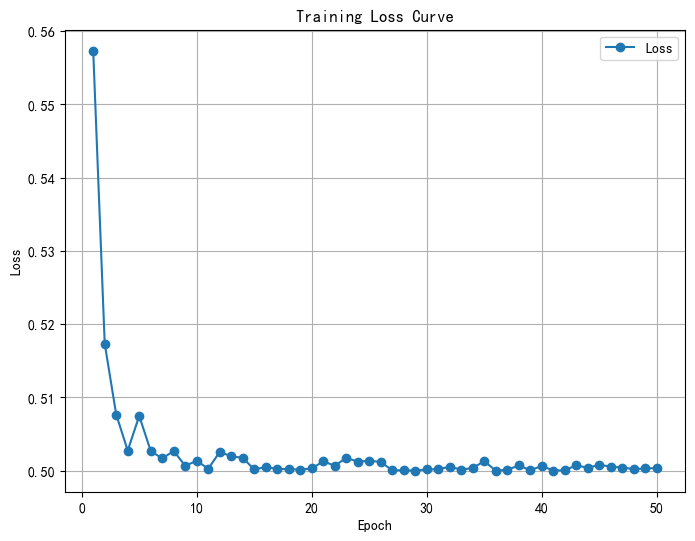

In [5]:
# 假设 hsi_data 是原始高光谱数据: [144, H, W]
pca_data, _ = apply_pca_train_only(casi, candidate_truth, num_components=8)
lda_data = apply_lda_train_only(casi, candidate_truth, num_components=8)

# 选点（如所有 train_truth、或 valid 区域）
coords = list(zip(candidate_truth.row, candidate_truth.col))

# 创建 Dataset 和 DataLoader
dataset = PCA_LDA_PatchDataset(pca_data, lda_data, coords)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

# 初始化网络
feature_extractor = FeatureExtractor(input_channels=8).cuda()  
projection_head = ProjectionHead(input_dim=128, output_dim=8).cuda()
optimizer = optim.Adam(list(feature_extractor.parameters()) + list(projection_head.parameters()), lr=1e-4)

# 创建保存模型的文件夹
os.makedirs('./pth', exist_ok=True)

# 训练循环
num_epochs = 50
temperature = 1
loss_values = []
neg = 5
for epoch in range(num_epochs):
    feature_extractor.train()
    projection_head.train()
    
    epoch_loss = 0
    for cube_pca, cube_lda in dataloader:
        cube_pca, cube_lda = cube_pca.cuda(), cube_lda.cuda()
        
        feat_pca = feature_extractor(cube_pca)
        feat_lda = feature_extractor(cube_lda)
        
        proj_pca = projection_head(feat_pca)
        proj_lda = projection_head(feat_lda)

        
        loss = contrastive_loss(proj_pca, proj_lda, temperature)
        #loss = contrastive_loss(proj_a, proj_b, margin=1.0, num_negatives=2)  # 或 margin=0.5
        #loss = contrastive_loss_ce_hard_negatives(proj_pca, proj_pca, temperature=1, num_negatives=neg)

        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(dataloader)
    loss_values.append(avg_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# 仅保存最后一个模型
model_path = 'final/hu_lda_oldloss.pth'
torch.save(
    {
        'epoch': num_epochs,
        'feature_extractor_state_dict': feature_extractor.state_dict(),
        'projection_head_state_dict': projection_head.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss_values[-1],
    },
    model_path
)
print(f"Final model saved to {model_path}")

# 绘制损失曲线
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), loss_values, marker='o', label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.grid()
plt.savefig('final/hulda_oldloss.png')
plt.show()


In [6]:
from collections import Counter
from torch.utils.data import Dataset, DataLoader
import random
from collections import defaultdict
import numpy as np
import torch
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
def extract_labels(truth, label_dict):
    """
    从稀疏矩阵中提取标注数据，格式为 [(row, col, label), ...]。
    并将标签值映射到 [0, len(label_dict)-1] 的范围。
    """
    rows, cols, labels = truth.row, truth.col, truth.data
    # 创建从标签值到索引的映射
    label_to_index = {label_value: idx for idx, label_value in enumerate(label_dict.keys())}
    mapped_labels = [label_to_index[label] for label in labels if label in label_to_index]
    return [(row, col, label) for row, col, label in zip(rows, cols, mapped_labels)]


# 分类数据集定义
class ClassificationDataset(Dataset):
    def __init__(self, data, labels, patch_size=11):
        """
        构造分类数据集。
        参数:
            data: PCA 降维后的数据 [C, H, W]
            labels: [(row, col, label), ...]，标注的样本
            patch_size: 立方块大小 (patch_size, patch_size)
        """
        self.data = data
        self.labels = labels
        self.patch_size = patch_size

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        x, y, label = self.labels[idx]
        cube = extract_cube(self.data, x, y, (self.patch_size, self.patch_size))  # 提取立方块
        cube_tensor = torch.tensor(cube).float()  # 转换为浮点张量
        return cube_tensor, torch.tensor(label - 1, dtype=torch.long)



# 定义特征提取器
class FeatureExtractor(nn.Module):
    def __init__(self, input_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = self.pool(self.relu(self.bn3(self.conv3(x))))
        return x.view(x.size(0), -1)  # Flatten to [batch_size, features]


class ClassificationHead(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(ClassificationHead, self).__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.fc(x)

torch.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)
random.seed(0)
num_classes = len(set(train_truth.data))

In [8]:
num_classes = len(set(train_truth.data))
# 从稀疏矩阵 train_truth 中提取训练样本标签 [(row, col, label), ...]
train_labels = [
    (r, c, label) 
    for r, c, label in zip(train_truth.row, train_truth.col, train_truth.data)
]

# 应用 PCA（在训练区域上）
#pca_data, explained_variance_ratio = apply_pca_train_only(pavia, train_truth, num_components=5)
# 先做 PCA 和 LDA 降维
pca_data, _ = apply_pca_train_only(casi, train_truth, num_components=4)
lda_data = apply_lda_train_only(casi, train_truth, num_components=4)

# 拼接 [C_pca + C_lda, H, W]
combined_data = np.concatenate([pca_data, lda_data], axis=0)

# 构造训练和测试数据集
train_dataset = ClassificationDataset(combined_data , train_labels, patch_size=11)

test_labels = [
    (r, c, label) 
    for r, c, label in zip(test_truth.row, test_truth.col, test_truth.data)
]
test_dataset = ClassificationDataset(combined_data, test_labels, patch_size=11)

# 定义 DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 打印样本信息
print(f"PCA 降维后的数据形状: {combined_data.shape}")
print(f"Number of training samples: {len(train_loader.dataset)}")
print(f"Number of testing samples: {len(test_loader.dataset)}")




# 加载对比学习的模型权重
#checkpoint_path = "./pth/model_epoch_160.pth"  # 修改为对比学习模型的路径
checkpoint_path = "final/hu_lda_oldloss.pth"
checkpoint = torch.load(checkpoint_path)

# 确保权重文件中包含特征提取器的权重
if 'feature_extractor_state_dict' not in checkpoint:
    raise KeyError("Checkpoint does not contain 'feature_extractor_state_dict'. Please check the file.")

PCA 降维后的数据形状: (8, 349, 1905)
Number of training samples: 225
Number of testing samples: 12197


In [9]:

# 初始化特征提取器（与对比学习阶段一致的输入通道数为 25）
feature_extractor = FeatureExtractor(input_channels=8).cuda()

# 加载所有预训练权重
feature_extractor.load_state_dict(checkpoint['feature_extractor_state_dict'])
print("Loaded pre-trained weights for the entire feature extractor.")

# 检查冻结状态（设置所有层参数为可微调）
for param in feature_extractor.parameters():
    param.requires_grad = True  # 解冻所有参数

# 修改输入维度为 128（特征提取器的输出维度）
classification_head = ClassificationHead(input_dim=128, num_classes=15).cuda()


# 定义优化器
optimizer = optim.Adam([
    {"params": feature_extractor.parameters(), "lr": 1e-4},  # 微调特征提取器
    {"params": classification_head.parameters(), "lr": 1e-3},  # 分类头
])

# 定义损失函数
criterion = nn.CrossEntropyLoss()

loss_values = []

def train_classification_model(feature_extractor, classification_head, train_loader, optimizer, criterion, num_epochs=50):
    feature_extractor.train()
    classification_head.train()

    for epoch in range(num_epochs):
        epoch_loss = 0
        for cubes, labels in train_loader:
            cubes, labels = cubes.cuda(), labels.cuda()
            features = feature_extractor(cubes)
            outputs = classification_head(features)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        loss_values.append(avg_loss)  # 记录损失值

        #print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# 运行训练函数
train_classification_model(feature_extractor, classification_head, train_loader, optimizer, criterion, num_epochs=200)



Loaded pre-trained weights for the entire feature extractor.


In [8]:
import torch
from sklearn.metrics import cohen_kappa_score

def evaluate_classification_model_with_details(feature_extractor, classification_head, test_loader, num_classes):
    """
    评估分类模型的性能，并输出详细预测结果和分布。

    参数:
        feature_extractor: 冻结的特征提取器
        classification_head: 分类头
        test_loader: 测试数据加载器
        num_classes: 总类别数
    """
    feature_extractor.eval()
    classification_head.eval()

    correct = 0
    total = 0

    # 初始化预测计数，并移动到 GPU
    prediction_counts = torch.zeros(num_classes, dtype=torch.int64).cuda()
    class_correct = torch.zeros(num_classes, dtype=torch.int64).cuda()
    class_total = torch.zeros(num_classes, dtype=torch.int64).cuda()

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for cubes, labels in test_loader:
            cubes, labels = cubes.cuda(), labels.cuda()

            # 提取特征并进行预测
            features = feature_extractor(cubes)
            outputs = classification_head(features)
            _, predicted = torch.max(outputs, 1)

            # 更新统计信息
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            prediction_counts += torch.bincount(predicted, minlength=num_classes).cuda()

            for i in range(labels.size(0)):
                label = labels[i].item()
                pred = predicted[i].item()
                class_total[label] += 1
                if label == pred:
                    class_correct[label] += 1

            # 保存详细信息
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Overall Accuracy
    overall_accuracy = correct / total

    # Average Accuracy (每个类别的平均准确率)
    average_accuracy = (class_correct.float() / class_total.float()).mean().item()

    # Per-class Accuracy
    per_class_accuracy = class_correct.float() / class_total.float()

    # Kappa 系数
    kappa = cohen_kappa_score(all_labels, all_predictions)

    print(f"Overall Accuracy: {overall_accuracy:.4f}")
    print(f"Average Accuracy: {average_accuracy:.4f}")
    print(f"Kappa Coefficient: {kappa:.4f}")

    print("\nPrediction Distribution:")
    for cls, count in enumerate(prediction_counts.cpu()):  # 将分布从 GPU 移回 CPU
        print(f"Class {cls}: {count} predictions")

    print("\nPer-class Accuracy:")
    for cls, acc in enumerate(per_class_accuracy):
        print(f"Class {cls}: {acc:.4f}")
    for cls, acc in enumerate(per_class_accuracy):
        print(f"{acc:.4f}")
    return overall_accuracy, average_accuracy, kappa, all_predictions, all_labels, per_class_accuracy.cpu().numpy()


# 调用示例
overall_accuracy, average_accuracy, kappa, all_predictions, all_labels, per_class_accuracy = evaluate_classification_model_with_details(
    feature_extractor, classification_head, test_loader, num_classes=num_classes
)


Overall Accuracy: 0.7407
Average Accuracy: 0.7560
Kappa Coefficient: 0.7200

Prediction Distribution:
Class 0: 891 predictions
Class 1: 911 predictions
Class 2: 1725 predictions
Class 3: 966 predictions
Class 4: 1110 predictions
Class 5: 124 predictions
Class 6: 1191 predictions
Class 7: 763 predictions
Class 8: 938 predictions
Class 9: 675 predictions
Class 10: 777 predictions
Class 11: 972 predictions
Class 12: 354 predictions
Class 13: 312 predictions
Class 14: 488 predictions

Per-class Accuracy:
Class 0: 0.8272
Class 1: 0.8233
Class 2: 0.7802
Class 3: 0.8996
Class 4: 0.9934
Class 5: 0.6643
Class 6: 0.8368
Class 7: 0.4501
Class 8: 0.6799
Class 9: 0.4517
Class 10: 0.5731
Class 11: 0.6878
Class 12: 0.9053
Class 13: 0.7692
Class 14: 0.9979
0.8272
0.8233
0.7802
0.8996
0.9934
0.6643
0.8368
0.4501
0.6799
0.4517
0.5731
0.6878
0.9053
0.7692
0.9979
